In [1]:
import numpy as np
np.bool = np.bool_
import pandas as pd
from ISLP.models import (summarize, poly, ModelSpec as MS)
import statsmodels.api as sm
from matplotlib.pyplot import subplots 
from ISLP.models import bs, ns
from pygam import (s as s_gam, l as l_gam, f as f_gam, LinearGAM, LogisticGAM)
from ISLP.pygam import (approx_lam, degrees_of_freedom, plot as plot_gam, anova as anova_gam)

### Problem 1

In [2]:
np.random.seed(1)
x = np.random.normal(0, 1, 100)
error = np.random.normal(0, 1, 100)
y = np.sin(x/2) + error
x = pd.DataFrame(data = x[:,], columns = ['x'])
y = pd.DataFrame(data = y[:,], columns = ['y'])

#### (a)

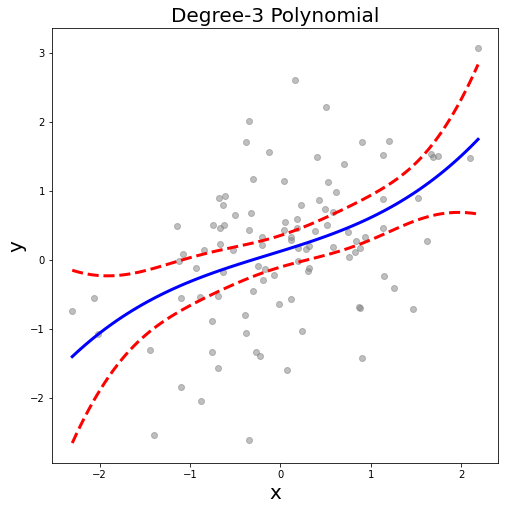

In [3]:
cub_x = MS([poly('x', degree=3)]).fit(x)
cub_fit = sm.OLS(y, cub_x.transform(x)).fit()
x_grid = np.linspace(x['x'].min(), x['x'].max(),100)
x_df = pd.DataFrame({'x': x_grid})
def plot_fit(x_df, basis, title):
    X = basis.transform(x)
    Xnew = basis.transform(x_df)
    M = sm.OLS(y, X).fit()
    preds = M.get_prediction(Xnew) 
    bands = preds.conf_int(alpha=0.05) 
    fig, ax = subplots(figsize=(8,8))
    ax.scatter(x['x'], y['y'], facecolor='gray',alpha=0.5)
    for val, ls in zip([preds.predicted_mean, bands[:,0], bands[:,1]], ['b','r--','r--']):
        ax.plot(x_df.values, val, ls, linewidth=3) 
        ax.set_title(title, fontsize=20) 
        ax.set_xlabel('x', fontsize=20) 
        ax.set_ylabel('y', fontsize=20);
    return ax
plot_fit(x_df, cub_x,'Degree-3 Polynomial');

#### (b)

In [4]:
def crossval(pred, response, k, df, spline):
    split = pred.shape[0]//k
    rss_list = []
    for i in range(k):
        if i != max(range(k)):
            pred_val = pred['x'][i*split:(i+1)*split]
            y_val = response['y'][i*split:(i+1)*split]
            pred_train = np.concatenate((pred['x'][:i*split], pred['x'][(i+1)*split:]))
            y_train = np.concatenate((response['y'][:i*split], response['y'][(i+1)*split:]))
        else:
            pred_val = pred['x'][i*split:]
            y_val = response['y'][i*split:]
            pred_train = pred['x'][:i*split]
            y_train = response['y'][:i*split]
        pred_train = pd.DataFrame(data = pred_train[:,], columns = ['x'])
        y_train = pd.DataFrame(data = y_train[:,], columns = ['y'])
        pred_val = pd.DataFrame(data = pred_val[:,], columns = ['x'])
        y_val = pd.DataFrame(data = y_val[:,], columns = ['y'])
        bs_x = MS([spline('x', df=df, intercept=True)]).fit(pred_train)
        results = sm.OLS(y_train, bs_x.transform(pred_train)).fit()
        test_pred = results.predict(bs_x.transform(pred_val))
        rss = (np.sum((y_val['y'] - test_pred)**2))
        rss_list.append(rss)
    return np.mean(rss_list)

[18.247085021997236, 17.69475611082384, 18.182567538120438, 18.523207448480395, 19.757490106582583]


<AxesSubplot:title={'center':'Degree-3 Spline with 3 Knots'}, xlabel='x', ylabel='y'>

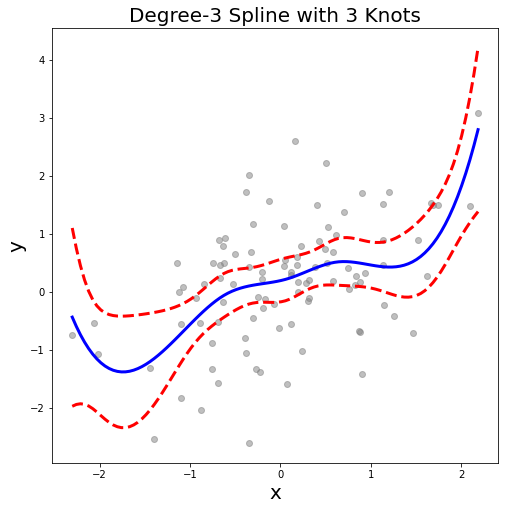

In [6]:
cv_list = []
for i in [6,7,8,9,10]:
    cv_list.append(crossval(x, y, 5, i, bs))
print(cv_list)
bs_x = MS([bs('x', df=7, intercept=True)]).fit(x)
M = sm.OLS(y, bs_x.transform(x)).fit()
plot_fit(x_df, bs_x,'Degree-3 Spline with 3 Knots')

#### (c)

[18.358775621312212, 18.768414017050482, 19.257951437066232, 18.28796013907146, 18.714047376297703]


<AxesSubplot:title={'center':'Degree-3 Spline with 5 Knots'}, xlabel='x', ylabel='y'>

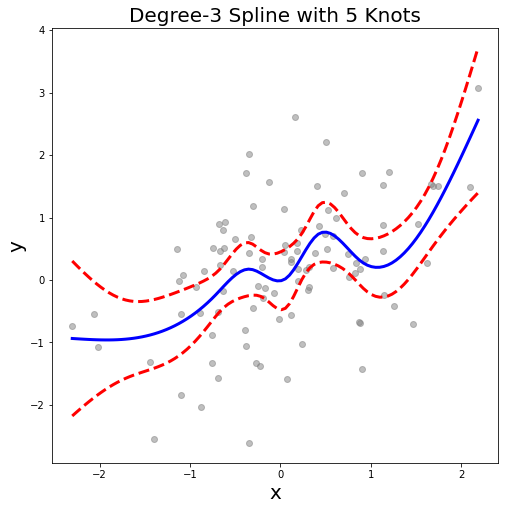

In [7]:
cv_list = []
for i in [4,5,6,7,8]:
    cv_list.append(crossval(x, y, 5, i, ns))
print(cv_list)
bs_x = MS([ns('x', df=7, intercept=True)]).fit(x)
M = sm.OLS(y, bs_x.transform(x)).fit()
plot_fit(x_df, bs_x,'Degree-3 Spline with 5 Knots')

#### (d)

In [8]:
def crossval(pred, response, k, lam):
    split = pred.shape[0]//k
    rss_list = []
    for i in range(k):
        if i != max(range(k)):
            pred_val = pred['x'][i*split:(i+1)*split]
            y_val = response['y'][i*split:(i+1)*split]
            pred_train = np.concatenate((pred['x'][:i*split], pred['x'][(i+1)*split:]))
            y_train = np.concatenate((response['y'][:i*split], response['y'][(i+1)*split:]))
        else:
            pred_val = pred['x'][i*split:]
            y_val = response['y'][i*split:]
            pred_train = pred['x'][:i*split]
            y_train = response['y'][:i*split]
        
        pred_train = pd.DataFrame(data = pred_train[:,], columns = ['x'])
        y_train = pd.DataFrame(data = y_train[:,], columns = ['y'])
        pred_val = pd.DataFrame(data = pred_val[:,], columns = ['x'])
        y_val = pd.DataFrame(data = y_val[:,], columns = ['y'])
        
        x_train = np.asarray(pred_train['x']).reshape((-1,1))
        x_val = np.asarray(pred_val['x']).reshape((-1,1))
        
        gam = LinearGAM(s_gam(0, lam=lam)).fit(x_train, y_train)
        val_pred = gam.predict(x_val)
        rss = (np.sum((y_val['y'] - val_pred)**2))
        rss_list.append(rss)

    return np.mean(rss_list), lam

In [9]:
cv_list = []
for i in np.logspace(-2, 6, 5):
    cv_list.append(crossval(x, y, 5, i))

1000000.0


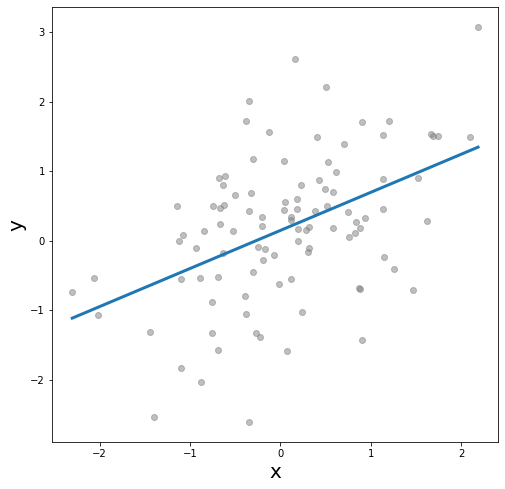

In [10]:
lam_opt = min(cv_list)[1]
print(lam_opt)
x_grid = np.linspace(x['x'].min(), x['x'].max(),100)
fig, ax = subplots(figsize=(8,8))
x_sm = np.asarray(x['x']).reshape((-1,1))
ax.scatter(x['x'], y['y'], facecolor='gray', alpha=0.5)
gam = LinearGAM(s_gam(0, lam=lam_opt)).fit(x_sm, y)
ax.plot(x_grid, gam.predict(x_grid), linewidth=3)
ax.set_xlabel('x', fontsize=20)
ax.set_ylabel('y', fontsize=20);

### Problem 2

In [11]:
air = pd.read_csv('/Users/zach/Jupyter/DATA 558/airquality.csv')
air = air.drop(columns=['Unnamed: 0'])
air['cub_Ozone'] = np.cbrt(air['Ozone'])
air = air.drop(columns=['Ozone'])
air = air.dropna(axis=0)

#### (a)

In [12]:
air.columns

Index(['Solar.R', 'Wind', 'Temp', 'Month', 'Day', 'cub_Ozone'], dtype='object')

In [13]:
def crossval(pred, response, k, lam):
    split = pred.shape[0]//k
    rss_list = []
    for i in range(k):
        if i != max(range(k)):
            pred_val = pred['x'][i*split:(i+1)*split]
            y_val = response['y'][i*split:(i+1)*split]
            pred_train = np.concatenate((pred['x'][:i*split], pred['x'][(i+1)*split:]))
            y_train = np.concatenate((response['y'][:i*split], response['y'][(i+1)*split:]))
        else:
            pred_val = pred['x'][i*split:]
            y_val = response['y'][i*split:]
            pred_train = pred['x'][:i*split]
            y_train = response['y'][:i*split]
        
        pred_train = pd.DataFrame(data = pred_train[:,], columns = ['x'])
        y_train = pd.DataFrame(data = y_train[:,], columns = ['y'])
        pred_val = pd.DataFrame(data = pred_val[:,], columns = ['x'])
        y_val = pd.DataFrame(data = y_val[:,], columns = ['y'])
        
        x_train = np.asarray(pred_train['x']).reshape((-1,1))
        x_val = np.asarray(pred_val['x']).reshape((-1,1))
        
        gam = LinearGAM(s_gam(0, lam=lam)).fit(x_train, y_train)
        val_pred = gam.predict(x_val)
        rss = (np.sum((y_val['y'] - val_pred)**2))
        rss_list.append(rss)

    return np.mean(rss_list), lam

100.0
100.0
0.01
100.0
100.0


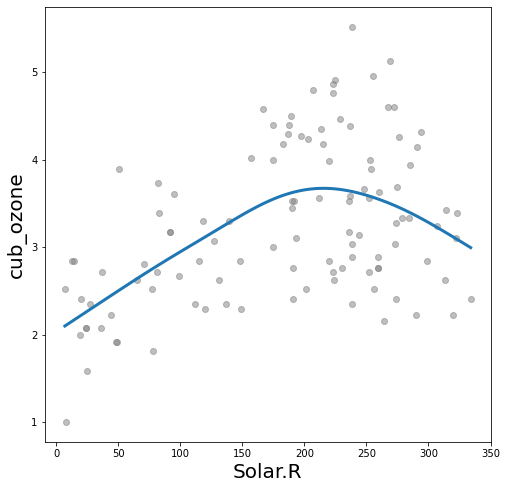

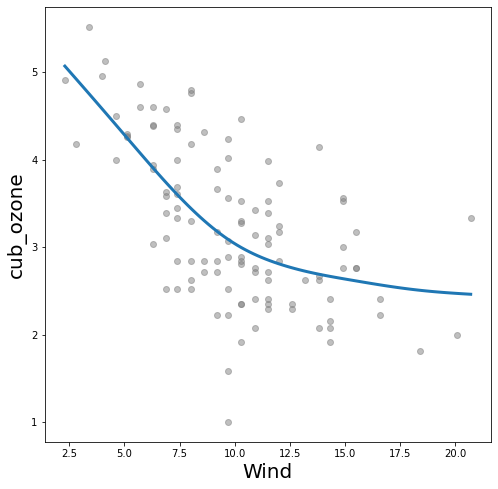

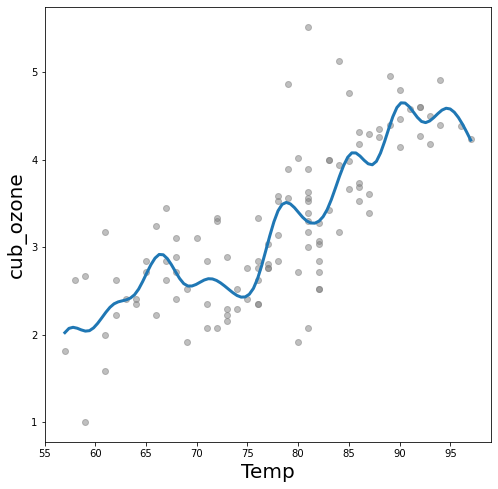

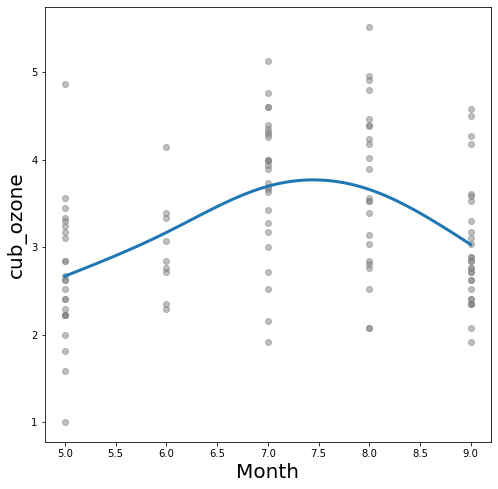

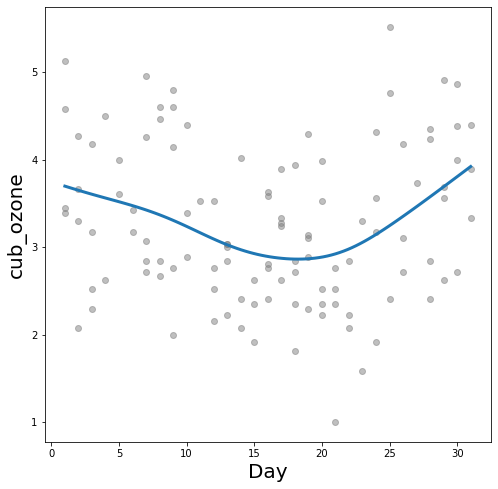

In [14]:
y = air[['cub_Ozone']]
y = y.rename(columns={"cub_Ozone": "y"})
for var in ['Solar.R', 'Wind', 'Temp', 'Month', 'Day']:
    x = air[[var]]
    x = x.rename(columns={var: "x"})
    cv_list = []
    for i in np.logspace(-2, 6, 5):
        cv_list.append(crossval(x, y, 5, i))
    print(min(cv_list)[1])
    lam_opt = min(cv_list)[1]
    x_grid = np.linspace(x['x'].min(), x['x'].max(),100)
    fig, ax = subplots(figsize=(8,8))
    x_sm = np.asarray(x['x']).reshape((-1,1))
    ax.scatter(x['x'], y['y'], facecolor='gray', alpha=0.5)
    gam = LinearGAM(s_gam(0, lam=lam_opt)).fit(x_sm, y) 
    ax.plot(x_grid, gam.predict(x_grid), linewidth=3)
    ax.set_xlabel(var, fontsize=20) 
    ax.set_ylabel('cub_ozone', fontsize=20);

#### (b)

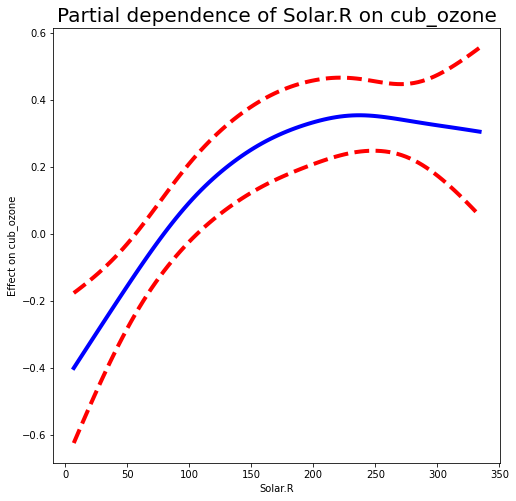

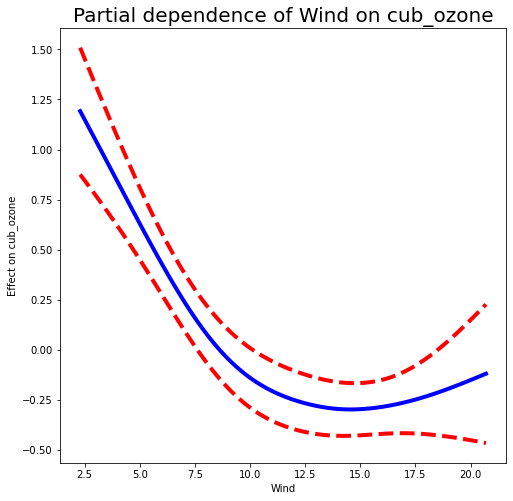

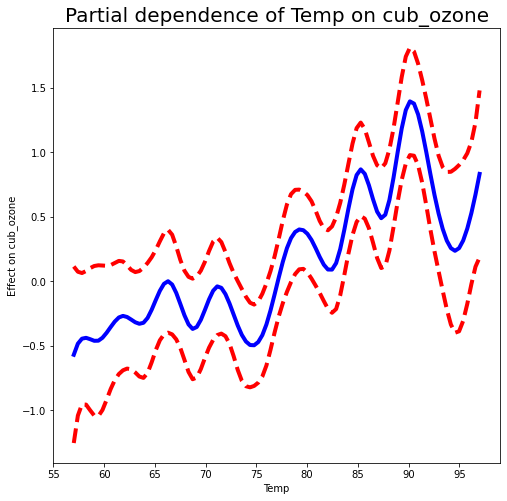

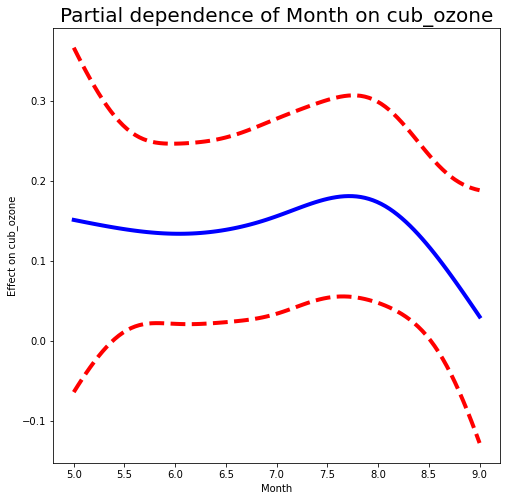

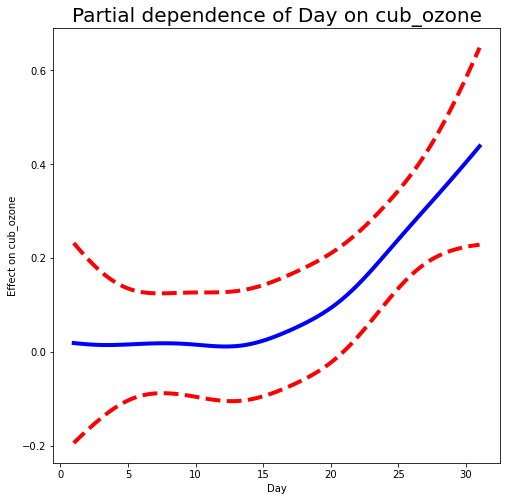

In [15]:
gam_full = LinearGAM(s_gam(0, lam=100) + s_gam(1, lam=100) + s_gam(2, lam=0.01) + s_gam(3, lam=100) + s_gam(4, lam=100)) 
Xgam = np.column_stack([air['Solar.R'], air['Wind'], air['Temp'], air['Month'], air['Day']]) 
gam_full = gam_full.fit(Xgam, y)

fig, ax = subplots(figsize=(8,8))
plot_gam(gam_full, 0, ax=ax)
ax.set_xlabel('Solar.R')
ax.set_ylabel('Effect on cub_ozone')
ax.set_title('Partial dependence of Solar.R on cub_ozone',fontsize=20);

fig, ax = subplots(figsize=(8,8))
plot_gam(gam_full, 1, ax=ax)
ax.set_xlabel('Wind')
ax.set_ylabel('Effect on cub_ozone')
ax.set_title('Partial dependence of Wind on cub_ozone',fontsize=20);

fig, ax = subplots(figsize=(8,8))
plot_gam(gam_full, 2, ax=ax)
ax.set_xlabel('Temp')
ax.set_ylabel('Effect on cub_ozone')
ax.set_title('Partial dependence of Temp on cub_ozone',fontsize=20);

fig, ax = subplots(figsize=(8,8))
plot_gam(gam_full, 3, ax=ax)
ax.set_xlabel('Month')
ax.set_ylabel('Effect on cub_ozone')
ax.set_title('Partial dependence of Month on cub_ozone',fontsize=20);

fig, ax = subplots(figsize=(8,8))
plot_gam(gam_full, 4, ax=ax)
ax.set_xlabel('Day')
ax.set_ylabel('Effect on cub_ozone')
ax.set_title('Partial dependence of Day on cub_ozone',fontsize=20);

#### (c)

Text(0, 0.5, 'Residuals')

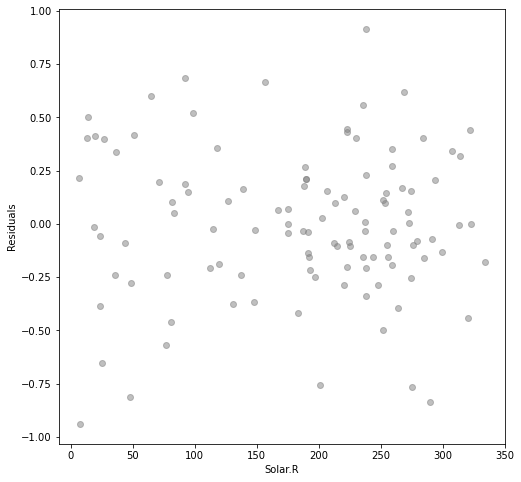

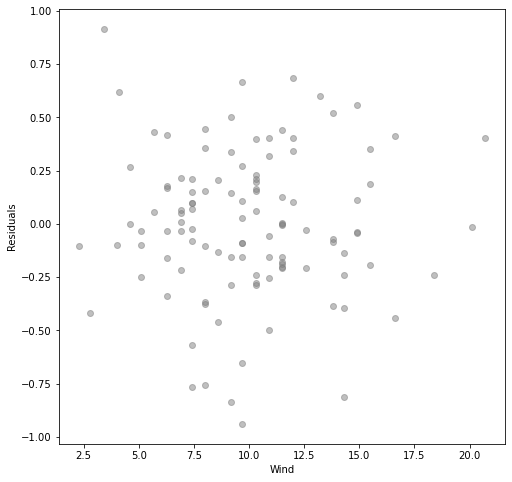

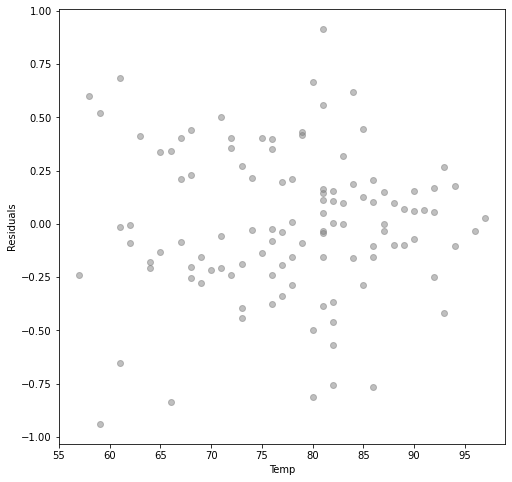

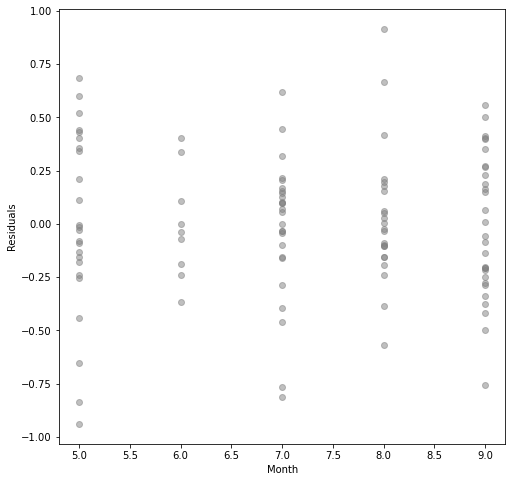

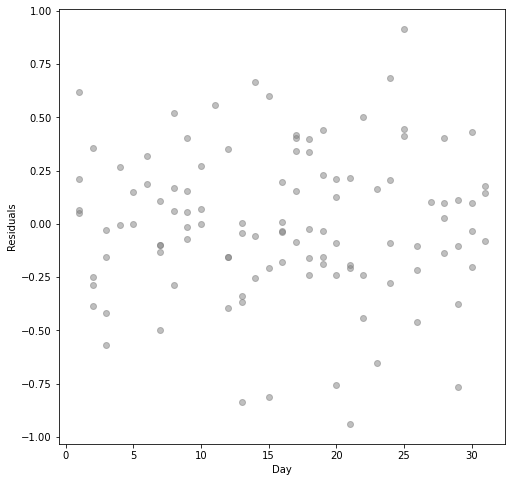

In [16]:
preds = gam_full.predict(Xgam)
res = y['y'] - preds

fig, ax = subplots(figsize=(8,8))
ax.scatter(air['Solar.R'], res, facecolor='gray', alpha=0.5)
ax.set_xlabel('Solar.R')
ax.set_ylabel('Residuals')

fig, ax = subplots(figsize=(8,8))
ax.scatter(air['Wind'], res, facecolor='gray', alpha=0.5)
ax.set_xlabel('Wind')
ax.set_ylabel('Residuals')

fig, ax = subplots(figsize=(8,8))
ax.scatter(air['Temp'], res, facecolor='gray', alpha=0.5)
ax.set_xlabel('Temp')
ax.set_ylabel('Residuals')

fig, ax = subplots(figsize=(8,8))
ax.scatter(air['Month'], res, facecolor='gray', alpha=0.5)
ax.set_xlabel('Month')
ax.set_ylabel('Residuals')

fig, ax = subplots(figsize=(8,8))
ax.scatter(air['Day'], res, facecolor='gray', alpha=0.5)
ax.set_xlabel('Day')
ax.set_ylabel('Residuals')